<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
from google.colab import drive

import os

In [ ]:
# 掛載 Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from collections import defaultdict

# 定義數據集根路徑
root_path = "/content/drive/MyDrive/HW3/MVTec_AD_Dataset"

# 用於儲存統計數據的字典
dataset_summary = defaultdict(lambda: defaultdict(int))

# 遍歷數據集目錄
for category in os.listdir(root_path):
    category_path = os.path.join(root_path, category)
    if os.path.isdir(category_path):
        for subdir in os.listdir(category_path):
            subdir_path = os.path.join(category_path, subdir)
            if os.path.isdir(subdir_path):
                # 處理二級子目錄（如 train, test, ground_truth）
                for subsubdir in os.listdir(subdir_path):
                    subsubdir_path = os.path.join(subdir_path, subsubdir)
                    if os.path.isdir(subsubdir_path):
                        # 計算檔案數量
                        file_count = len([f for f in os.listdir(subsubdir_path) if f.endswith('.png')])
                        dataset_summary[category][f"{subdir}/{subsubdir}"] = file_count
                    else:
                        # 如果是直接檔案（如 hazelnut/train/good）
                        file_count = len([f for f in os.listdir(subdir_path) if f.endswith('.png')])
                        dataset_summary[category][subdir] = file_count

# 輸出總結
print("MVTec AD Dataset Summary (March 29, 2025):")
print("=========================================")
for category, subdirs in dataset_summary.items():
    print(f"\nCategory: {category}")
    total_files = sum(subdirs.values())
    print(f"Total files: {total_files}")
    for subdir, count in subdirs.items():
        print(f"  {subdir}: {count} files")

# 計算整體統計
total_categories = len(dataset_summary)
total_files_all = sum(sum(subdirs.values()) for subdirs in dataset_summary.values())
print("\nOverall Statistics:")
print(f"Total Categories: {total_categories}")
print(f"Total Files: {total_files_all}")

MVTec AD Dataset Summary (March 29, 2025):

Category: hazelnut
Total files: 409
  train/good: 391 files
  test/hole: 18 files

Category: capsule
Total files: 459
  ground_truth/scratch: 23 files
  ground_truth/squeeze: 19 files
  ground_truth/poke: 21 files
  ground_truth/faulty_imprint: 22 files
  ground_truth/crack: 23 files
  test/squeeze: 20 files
  test/scratch: 23 files
  test/faulty_imprint: 22 files
  test/crack: 23 files
  test/good: 23 files
  test/poke: 21 files
  train/good: 219 files

Category: metal_nut
Total files: 340
  ground_truth/color: 22 files
  ground_truth/flip: 23 files
  ground_truth/scratch: 23 files
  ground_truth/bent: 25 files
  train/good: 199 files
  test/bent: 25 files
  test/scratch: 23 files

Category: tile
Total files: 200
  ground_truth/oil: 18 files
  ground_truth/glue_strip: 17 files
  ground_truth/crack: 17 files
  ground_truth/rough: 15 files
  ground_truth/gray_stroke: 16 files
  test/oil: 18 files
  test/gray_stroke: 16 files
  test/rough: 15 f

In [ ]:
import os
import cv2
import pandas as pd

def count_images_in_folder(folder, extensions=('.png', '.jpg')):
    """遞迴計算指定資料夾內符合副檔名的影像檔數量。"""
    count = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                count += 1
    return count

def get_sample_image_from_folder(folder, extensions=('.png', '.jpg')):
    """
    遞迴搜尋指定資料夾內第一張符合副檔名的影像，
    若成功讀取則傳回 (影像路徑, 影像尺寸)；否則回傳 (None, None)。
    """
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                img_path = os.path.join(root, f)
                img = cv2.imread(img_path)
                if img is not None:
                    return img_path, img.shape  # (height, width, channels)
    return None, None

# 定義數據集根路徑（請確認此路徑存在）
root_path = "/content/drive/MyDrive/HW3/MVTec_AD_Dataset"
if not os.path.exists(root_path):
    raise FileNotFoundError(f"找不到資料夾: {root_path}")

# 取得所有產品類別（根目錄下的子資料夾）
categories = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
if not categories:
    raise Exception("根目錄下沒有找到任何子資料夾，請確認資料夾結構正確。")

summary = []

for category in sorted(categories):
    category_path = os.path.join(root_path, category)
    # 遞迴統計整個 Category 內的影像數量
    total_images = count_images_in_folder(category_path)

    # 若存在 train 資料夾則統計 train 影像數量
    train_images = 0
    train_folder = os.path.join(category_path, "train")
    if os.path.isdir(train_folder):
        train_images = count_images_in_folder(train_folder)

    # 若存在 test 資料夾則統計 test 影像數量
    test_images = 0
    test_folder = os.path.join(category_path, "test")
    if os.path.isdir(test_folder):
        test_images = count_images_in_folder(test_folder)

    # 若存在 ground_truth 資料夾則統計其影像數量
    gt_images = 0
    gt_folder = os.path.join(category_path, "ground_truth")
    if os.path.isdir(gt_folder):
        gt_images = count_images_in_folder(gt_folder)

    # 缺陷類別統計：
    # 以 test 資料夾中除 "good" 外的子資料夾名稱作為缺陷類別，
    # 若 test 資料夾不存在則以 ground_truth 的子資料夾作為依據。
    defect_types = set()
    if os.path.isdir(test_folder):
        for sub in os.listdir(test_folder):
            sub_path = os.path.join(test_folder, sub)
            if os.path.isdir(sub_path) and sub.lower() != "good":
                defect_types.add(sub)
    elif os.path.isdir(gt_folder):
        for sub in os.listdir(gt_folder):
            sub_path = os.path.join(gt_folder, sub)
            if os.path.isdir(sub_path):
                defect_types.add(sub)

    # 取得範例影像尺寸：從 category 內遞迴找出第一張影像
    sample_img_path, sample_shape = get_sample_image_from_folder(category_path)
    dims_str = "N/A"
    if sample_shape is not None:
        h, w, c = sample_shape
        dims_str = f"{h}x{w}x{c}"

    summary.append({
        "Category": category,
        "Total Images": total_images,
        "Train Images": train_images,
        "Test Images": test_images,
        "Ground Truth Images": gt_images,
        "# Defect Classes": len(defect_types),
        "Defect Types": ", ".join(sorted(defect_types)) if defect_types else "None",
        "Image Dimensions": dims_str
    })

# 將結果轉換成 DataFrame 並印出統計表
df_summary = pd.DataFrame(summary)
print("MVTec AD Dataset Full Summary:")
print("================================")
print(df_summary)

# 如有需要，存成 CSV 檔案
output_csv = "/content/drive/MyDrive/HW3/mvtec_dataset_statistics.csv"
df_summary.to_csv(output_csv, index=False)
print(f"\n統計結果已儲存至： {output_csv}")


MVTec AD Dataset Full Summary:
      Category  Total Images  Train Images  Test Images  Ground Truth Images  \
0       bottle           229           209           20                    0   
1        cable            55             0            0                   55   
2      capsule           459           219          132                  108   
3       carpet            98             0           45                   53   
4         grid            56             0           34                   22   
5     hazelnut           409           391           18                    0   
6      leather           135            15           69                   51   
7    metal_nut           340           199           48                   93   
8         pill            78             0           40                   38   
9        screw           374           119          160                   95   
10        tile           200             0          117                   83   
11  tooth

In [ ]:
import os
import glob

# 搜尋指定路徑下所有 .png 檔案（假設路徑正確）
file_paths = glob.glob('/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/*/*/*.png')

# 印出找到的檔案數量與前 5 個檔案路徑
print("img count：", len(file_paths))
print("first 5 img：", file_paths[:5])

# 建立期望的檔名清單：'000_mask.png' 到 '009_mask.png'
expected_names = [f"{i:03}_mask.png" for i in range(10)]
print("expected names：", expected_names)

# 篩選出檔名為 '000_mask.png' 到 '009_mask.png' 的檔案
filtered_paths = sorted([
    path for path in file_paths
    if os.path.basename(path) in expected_names
])

print("filtered img：", len(filtered_paths))
print("first 5 filtered img：", filtered_paths[:5])


img count： 55
first 5 img： ['/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/combined/005_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/combined/002_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/combined/004_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/combined/003_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/combined/009_mask.png']
expected names： ['000_mask.png', '001_mask.png', '002_mask.png', '003_mask.png', '004_mask.png', '005_mask.png', '006_mask.png', '007_mask.png', '008_mask.png', '009_mask.png']
filtered img： 49
first 5 filtered img： ['/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/bent_wire/000_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/bent_wire/001_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cable/ground_truth/bent_wire/003_mask.png', '/content/drive/MyDrive/HW3/MVTec_AD_Dataset/cab

In [ ]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/55 [00:00<?, ?it/s]

(55, 1024, 1024, 3)


Classes: ['bent_wire', 'combined', 'cut_outer_insulation', 'missing_cable', 'missing_wire']
Number of classes: 5
Class 0 (bent_wire): 12 images
Class 1 (combined): 11 images
Class 2 (cut_outer_insulation): 10 images
Class 3 (missing_cable): 12 images
Class 4 (missing_wire): 10 images


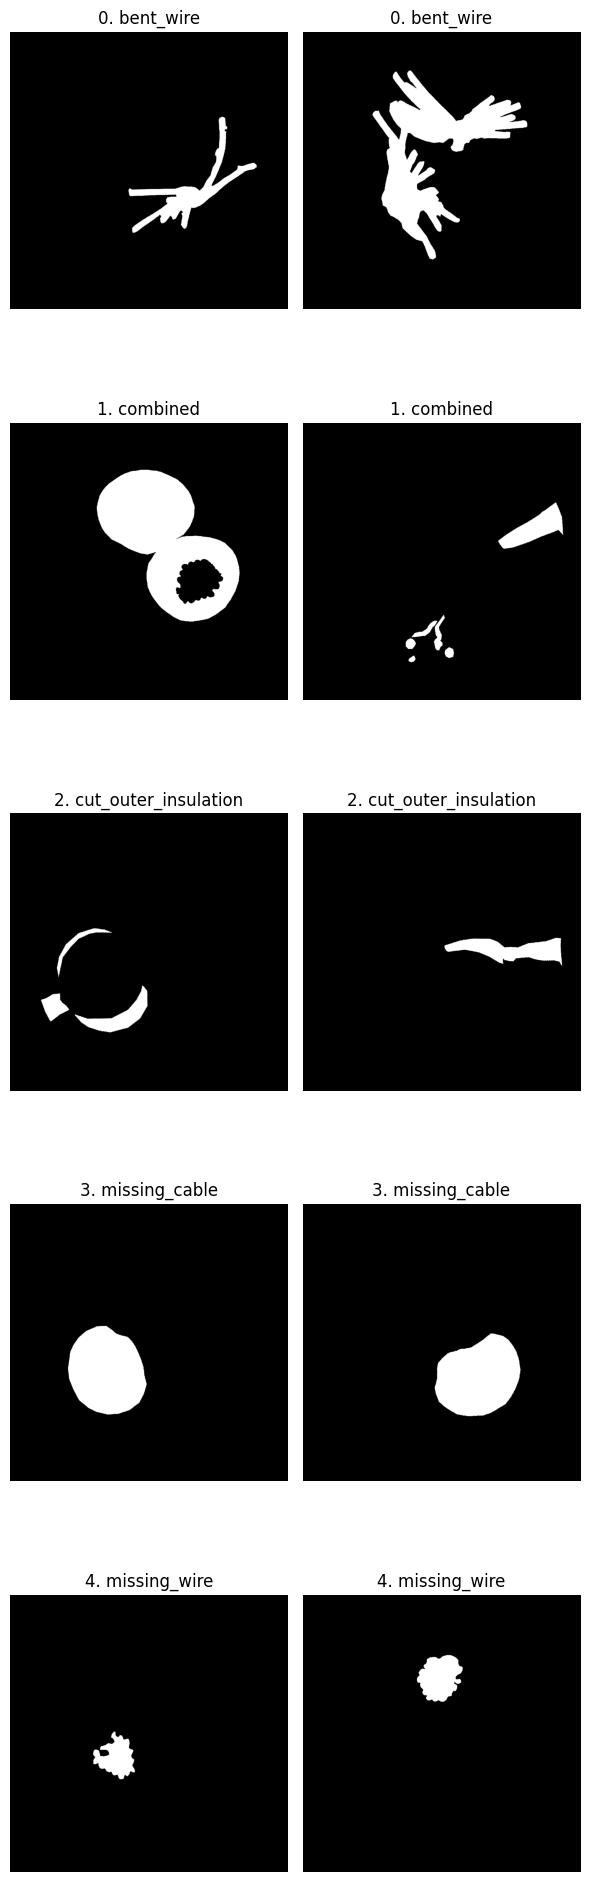

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# 假設 all_data 是你已經讀好的圖像陣列，file_paths 是圖像對應的路徑
# 例如 file_paths[0] = 'ground_truth/combined/img1.jpg'

# 取得類別名稱
classes = sorted(set([os.path.basename(os.path.dirname(path)) for path in file_paths]))
print(f'Classes: {classes}')
print(f'Number of classes: {len(classes)}')

# ✅ 建立每個類別對應的 index list
category_indices = {i: [] for i in range(len(classes))}  # 類別編號為 key，儲存 index list

# 將 file_paths 中的每張圖，依照其類別放到對應的 list 中
for idx, path in enumerate(file_paths):
    class_name = os.path.basename(os.path.dirname(path))
    class_idx = classes.index(class_name)
    category_indices[class_idx].append(idx)

# 確認每類的圖像數量
for class_idx, indices in category_indices.items():
    print(f"Class {class_idx} ({classes[class_idx]}): {len(indices)} images")

# 顯示圖片
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)), squeeze=False)

for i, class_name in enumerate(classes):
    # ✅ 改用 category_indices 中的 index
    indices = category_indices[i]
    for j in range(2):
        if j < len(indices):  # 防止類別中圖片少於2張
            index = indices[j]
            axs[i, j].set_title(f'{i}. {class_name}')
            axs[i, j].imshow(all_data[index])
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

# 假設 all_data 是圖像陣列，file_paths 是圖像對應的路徑列表
# e.g., file_paths[0] = 'ground_truth/combined/img1.jpg'

# 自動建立類別與索引列表
classes = sorted(set([os.path.basename(os.path.dirname(path)) for path in file_paths]))
category_indices = {i: [] for i in range(len(classes))}

for idx, path in enumerate(file_paths):
    class_name = os.path.basename(os.path.dirname(path))
    class_idx = classes.index(class_name)
    category_indices[class_idx].append(idx)

# 分割 train / val / test
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

for class_idx, indices in category_indices.items():
    total = len(indices)
    np.random.shuffle(indices)

    train_end = int(total * 0.7)
    val_end = int(total * 0.85)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    x_train.extend([all_data[i] for i in train_indices])
    y_train.extend([class_idx] * len(train_indices))

    x_val.extend([all_data[i] for i in val_indices])
    y_val.extend([class_idx] * len(val_indices))

    x_test.extend([all_data[i] for i in test_indices])
    y_test.extend([class_idx] * len(test_indices))

# 轉換為 numpy 陣列，並調整為 (N, C, H, W)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val   = np.transpose(np.array(x_val), (0, 3, 1, 2))
x_test  = np.transpose(np.array(x_test), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

# 顯示資料形狀
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val:   {x_val.shape}, y_val:   {y_val.shape}')
print(f'x_test:  {x_test.shape}, y_test:  {y_test.shape}')

# 建立 PyTorch TensorDataset 與 DataLoader
batch_size = 32
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train))
val_dataset   = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val))
test_dataset  = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x_train: (37, 3, 1024, 1024), y_train: (37,)
x_val:   (8, 3, 1024, 1024), y_val:   (8,)
x_test:  (10, 3, 1024, 1024), y_test:  (10,)


In [ ]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import random

# 自訂 Gaussian Noise Transform
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

# 自訂 Cutout Transform
class Cutout(object):
    def __init__(self, mask_size=8):
        self.mask_size = mask_size

    def __call__(self, img):
        c, h, w = img.size()
        y = random.randint(0, h)
        x = random.randint(0, w)

        y1 = max(0, y - self.mask_size // 2)
        y2 = min(h, y + self.mask_size // 2)
        x1 = max(0, x - self.mask_size // 2)
        x2 = min(w, x + self.mask_size // 2)

        img[:, y1:y2, x1:x2] = 0
        return img

normalize = transforms.Normalize(mean=[0.5], std=[0.5])  # ✅ 針對灰階圖像

# 資料增強最大化
# --- 資料增強 ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2)], p=0.7),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    Cutout(mask_size=8),
    transforms.Normalize([0.5], [0.5])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    normalize
])

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

## B. Defining Neural Networks

In [ ]:
import torch.nn as nn
import torch

class SmallIndustrialCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallIndustrialCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 初始化模型
model = SmallIndustrialCNN(num_classes=len(classes)).cuda()
#model = SmallIndustrialCNN(num_classes=len(classes)).to('cpu')
print(model)

SmallIndustrialCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13):

## C. Training the Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
from torch.utils.data import DataLoader # Importing DataLoader

# ---------- 初始化 ----------
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100
model = model.cuda()
#model = model.to('cpu')
best_val_acc = -1

# ✅ 使用 FocalLoss（不建議同時使用 label smoothing）
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# ✅ Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


# Assuming MyDataset, train_transforms, and val_transforms are defined
train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
val_dataset = MyDataset(x_val, y_val, transform=val_transforms)
test_dataset = MyDataset(x_test, y_test, transform=test_transforms)

batch_size = 37  # You might want to adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Creating train_loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Creating val_loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ OneCycleLR（每 batch 調整）
lr_scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4,
    verbose=False
)

# ---------- 訓練迴圈 ----------
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda().long()
        #images, labels = images.to('cpu'), labels.to('cpu').long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # 每 batch 更新 LR

        total_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # ---------- 驗證 ----------
    model.eval()
    total_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda().long()
            #images, labels = images.to('cpu'), labels.to('cpu').long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    current_lr = lr_scheduler.get_last_lr()[0]  # 取得當前學習率

    # ---------- Checkpoint ----------
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    # ---------- 顯示訓練資訊 ----------
    print(f"Epoch {epoch+1:02d}/{epochs:02d} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:6.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:6.2f}% | "
          f"Best Val Acc: {best_val_acc:6.2f}% | LR: {current_lr:.6f}")

    # ---------- 紀錄 ----------
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01/100 | Train Loss: 1.0376 | Train Acc:  18.92% | Val Loss: 1.0242 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000043
Epoch 02/100 | Train Loss: 1.0364 | Train Acc:  24.32% | Val Loss: 1.0226 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000051
Epoch 03/100 | Train Loss: 1.0179 | Train Acc:  13.51% | Val Loss: 1.0214 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000065
Epoch 04/100 | Train Loss: 1.0019 | Train Acc:  27.03% | Val Loss: 1.0204 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000084
Epoch 05/100 | Train Loss: 1.0193 | Train Acc:  21.62% | Val Loss: 1.0199 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000109
Epoch 06/100 | Train Loss: 0.9643 | Train Acc:  35.14% | Val Loss: 1.0198 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000138
Epoch 07/100 | Train Loss: 0.9624 | Train Acc:  35.14% | Val Loss: 1.0200 | Val Acc:  25.00% | Best Val Acc:  25.00% | LR: 0.000172
Epoch 08/100 | Train Loss: 0.9772 | Train Acc:  40.54% | Val Loss: 1.0207 | 

### Visualizing model performance

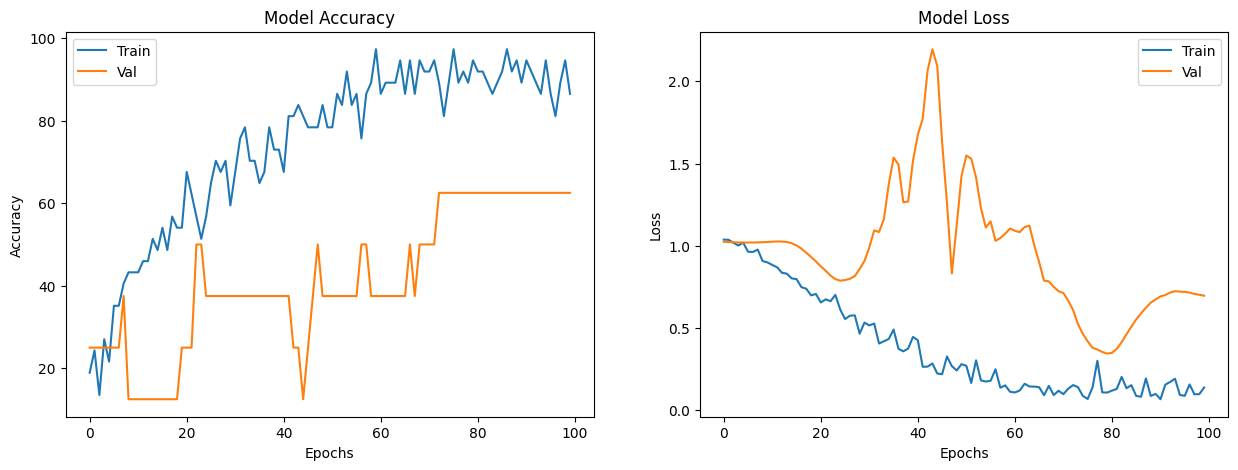

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:  # ✅ 使用 test_loader
        images = images.to("cuda")
        labels = labels.to("cuda").long()
        #images = images.to('cpu')
        #labels = labels.to('cpu').long()

        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total:.2f}%')

Test accuracy is 90.00%
